In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler #scaling de los datos entre 0 y 1
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
def format_l(df,l=1):
    n_datos_inc = df.shape[0] #cantidad total de meses
    n_filas = n_datos_inc - l #cantidad de filas de resultado
    res = np.zeros((n_filas,l+1))
    i = 0
    while i < n_filas:
        res[i] = df[i:i+l+1].flatten()
        i = i+1
    return res

In [17]:
#punto 1: cargo los datos y les hago un primer formatting
file_dir = 'airline-passengers.csv'
data = pd.read_csv(file_dir,sep=",",quotechar='"',na_values=[''])
df = pd.DataFrame(data)
df = df.drop(columns=['Month']) #no hace falta esta columna para nada
df = df.to_numpy() #me paso a numpy array
df_original = np.copy(df)

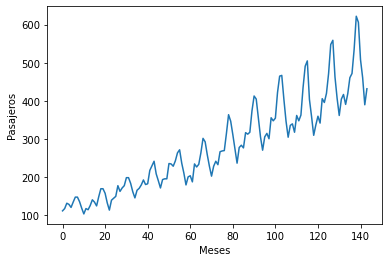

In [18]:
#grafico la serie temporal pasajeros-meses
plt.plot(df)
plt.xlabel('Meses')
plt.ylabel('Pasajeros')
plt.savefig('serie_temporal.pdf')

In [21]:
#punto 2: normalizo entre 0 y 1
l = 1
scaling = MinMaxScaler(feature_range=(0,1))
df = scaling.fit_transform(df)
df = format_l(df,l)

In [22]:
#punto 3: agrego ruido gaussiano pedido
df += np.random.normal(0,0.02,df.shape)

In [23]:
#punto 4: dividir en conjuntos de train y test
x = df[:,:l]
y = df[:,l:]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)

In [24]:
#punto 5: ajustar los datos para la capa LSTM (samples, time, features)
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [25]:
#punto 6: crear el modelo
model = keras.Sequential()
model.add(keras.layers.LSTM(4, input_shape=(1,l))) #input_shape = (1,l) sin el samples, analogo a redes anteriores
model.add(keras.layers.Dense(1))
#punto 7: entrenar la red
model.compile(optimizer='adam',loss=keras.losses.MSE) #no metrics porque seria mse, compilo
history = model.fit(x_train, y_train,epochs=100,batch_size=1,verbose=1) #entreno el modelo

Epoch 1/100
71/71 [==============================] - 0s 6ms/step - loss: 0.0683
Epoch 2/100
71/71 [==============================] - 0s 3ms/step - loss: 0.0366
Epoch 3/100
71/71 [==============================] - 0s 3ms/step - loss: 0.0260
Epoch 4/100
71/71 [==============================] - 0s 3ms/step - loss: 0.0223
Epoch 5/100
71/71 [==============================] - 0s 3ms/step - loss: 0.0201
Epoch 6/100
71/71 [==============================] - 0s 3ms/step - loss: 0.0183
Epoch 7/100
71/71 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 8/100
71/71 [==============================] - 0s 3ms/step - loss: 0.0150
Epoch 9/100
71/71 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 10/100
71/71 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 11/100
71/71 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 12/100
71/71 [==============================] - 0s 3ms/step - loss: 0.0095
Epoch 13/100
71/71 [=================

In [30]:
#punto 8: realizar predicciones
y_train_pr = model.predict(x_train)
y_test_pr = model.predict(x_test)
#invertir predicciones
y_train_pr = scaling.inverse_transform(y_train_pr)
y_train = scaling.inverse_transform(y_train)
y_test_pr = scaling.inverse_transform(y_test_pr)
y_test = scaling.inverse_transform(y_test)
#calcular el mse para test
print('MSE para train dataset:',round(np.square(y_train_pr-y_train).mean(),1))
print('MSE para test dataset:',round(np.square(y_test_pr-y_test).mean(),1))

MSE para train dataset: 6675864327778674.0
MSE para test dataset: 6706389689204337.0


In [28]:
trainPredictPlot = np.empty_like(df_original)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[l:len(y_train_pr)+l, :] = y_train_pr
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_original)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pr)+(l*2)+1:len(df_original)-1, :] = y_test_pr
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df_original), label="Airlines Data")
plt.plot(trainPredictPlot, label="Train Prediction")
plt.plot(testPredictPlot, label="Test Prediction")
plt.xlabel("Observations")
plt.ylabel("Passengers")
plt.legend()
plt.show()

ValueError: could not broadcast input array from shape (72,1) into shape (69,1)